# 注意力分数

$$f(x) = \sum_i \alpha(x,x_i)y_i = \sum_{i=1}^n softmax \left( - \frac {1}{2} {(x-x_i)}^2\right) y_i$$

我们将没有正则化过的权重$- \frac {1}{2} {(x-x_i)}^2$称为分数,也可以抽象化为$\alpha(x,x_i)$

## 扩展到高维度
假设query $\mathbf{q} \in \mathbb{R}^q$,我们有$m$对key-value $(\mathbf{k}_1,\mathbf{v}_1),\dots,$，其中$ k_i \in \mathbb{R}^k, v_i \in \mathbb{R}^v$

注意力池化（汇聚）层：
$$
f(\mathbf{q},(\mathbf{k}_1,\mathbf{v}_1),\dots,(\mathbf{k}_m,\mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q},\mathbf{k}_i)\mathbf{v}_i \in \mathbb{R}^v\\

\alpha(\mathbf{q},\mathbf{k}_i) = softmax(a(\mathbf{q},\mathbf{k}_i)) = \frac{\exp(a(\mathbf{q},\mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q},\mathbf{k}_j))} \in \mathbb{R}
$$

其中$a(\mathbf{q},\mathbf{k}_i)$就是注意力分数

## 可加的注意力 Additive Attention
可学参数：$ \mathbf{W}_k \in \mathbb{R}^{h\times k},\mathbf{W}_q \in \mathbb{R}^{h\times q},\mathbf{v}\in \mathbb{R}^{h}$

$$
a(\mathbf{k,q}) = \mathbf{v}^T tanh(\mathbf{W}_k \mathbf{k} + \mathbf{W}_q \mathbf{q})
$$

等价于将key和value合并起来之后放入到一个隐藏大小为h输出大小为1的MLP中

## 缩放点积注意力 Scaled Dot-Product Attention
如果查询和键都有一样的形状即 $ \mathbf{q,{k}_i} \in \mathbb{R}^d$，那么可以将注意力分数定义为:
$$a(\mathbf{q},\mathbf{k}_i) = \frac{<\mathbf{q},\mathbf{k}_i>}{\sqrt d} $$

## 总结
注意力分数是查询和键的相似度，注意力权重是分数的softmax结果

常见的分数计算有：
1. 将查询和键一起合并起来放入单输出单隐藏层的MLP
2. 直接将查询和键做内积（仅在他俩维度一样时可用）

In [6]:
import torch as t
import torch.nn as nn
from torch.nn.functional import softmax
import math
import sys
sys.path.append("../")
from pltutils import *

In [7]:
def masked_softmax(X:torch.Tensor,valid_lens:torch.Tensor):
    """
    softmax操作用于输出一个概率分布作为注意力权重。 
    在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。 
    例如，为了在 9.5节中高效处理小批量数据集， 某些文本序列被填充了没有意义的特殊词元。
    为了仅将有意义的词元作为值来获取注意力汇聚， 我们可以指定一个有效序列长度（即词元的个数），
    以便在计算softmax时过滤掉超出指定范围的位置。 
    通过这种方式，我们可以在下面的masked_softmax函数中 实现这样的掩蔽softmax操作（masked softmax operation），
    其中任何超出有效长度的位置都被掩蔽并置为0。
    """
    if valid_lens is None:
        return softmax(X,dim=-1)
    else:
        shape =X.shape
        if valid_lens.dim() ==1:
            valid_lens = t.repeat_interleave(valid_lens,shape[1])
        else:
            valid_lens=valid_lens.reshape(-1)
        # 最后一个轴上被这比的元素使用一个非常大的负值来替换，是softmax输出为0
        X=sequence_mask(X.reshape(-1,shape[-1]),valid_lens,value=-1e6)
        return softmax(X.reshape(shape),dim=-1)

In [8]:
# 试验一下
masked_softmax(t.rand(2,2,4),t.tensor([2,3]))

tensor([[[0.5149, 0.4851, 0.0000, 0.0000],
         [0.6058, 0.3942, 0.0000, 0.0000]],

        [[0.2425, 0.3650, 0.3926, 0.0000],
         [0.3033, 0.3341, 0.3625, 0.0000]]])

In [9]:
masked_softmax(t.rand(2,2,4),t.tensor([[1,3],[2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4033, 0.2262, 0.3706, 0.0000]],

        [[0.3172, 0.6828, 0.0000, 0.0000],
         [0.1706, 0.2662, 0.2490, 0.3142]]])

In [10]:
# 加性注意力
class AdditiveAttention(nn.Module):
    def __init__(self,key_size,query_size,num_hiddens,dropout,**kwargs):
        super().__init__(**kwargs)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=False)
        self.w_v=nn.Linear(num_hiddens,1,bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,queries,keys,values,valid_lens):
        queries,keys = self.W_q.forward(queries),self.W_k.forward(keys)
        # 维度扩展之后，
        # queries.shape = batch_size, num_queries, 1, num_hidden
        # key.shape = batch_size, 1, num_kvs , num_hiddens
        # 使用广播形式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = t.tanh(features)
        # self.w_v只有一个输出，因此从形状中移除最后的那个维度
        # socres.shape = batch_size, num_queries, num_kvs
        scores = self.w_v.forward(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores,valid_lens)
        return t.bmm(self.dropout(self.attention_weights),values)
        

In [19]:
# queries.shape and keys.shape and values.shape = batch_szie, num_steps, num_features
# output.shape = batch_size, query_steps, num_features

queries,keys = t.normal(0,1,(2,1,20)),t.ones((2,10,2))
values=t.arange(40,dtype=t.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens = t.tensor([2,6])

attention = AdditiveAttention(2,20,8,0.1)

attention .forward(queries,keys,values,valid_lens)

tensor([[[ 2.2222,  3.3333,  4.4444,  5.5556]],

        [[10.3704, 11.2963, 12.2222, 13.1481]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但是在这里每个键都是相同的，所以注意力全中是均匀的，由指定的有效长度决定

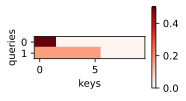

In [17]:
# show attention map
show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),xlabel="keys",ylabel="queries")

In [18]:
attention.attention_weights

tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)

# 缩放点积注意力

In [20]:
class DotProductAttention(nn.Module):
    def __init__(self,dropout,**kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self,queries,keys,values,valid_lens=None):
        d = queries.shape[-1]
        scores = t.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        self.attention_weights =masked_softmax(scores,valid_lens)
        return t.bmm(self.dropout(self.attention_weights),values)

In [21]:
#使用相同的有效值长度
queries = t.normal(0,1,(2,1,2))
attention = DotProductAttention(0.5)
attention.eval()
attention(queries,keys,values,valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

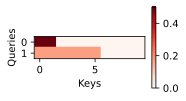

In [22]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
              xlabel='Keys', ylabel='Queries')
